In [14]:
'''
Visualize the data generated from src/cut_and_project/three_dim_commuting.py
'''
import os
import sys
sys.path.append('..')
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from aperiodic_codes import cut_and_project
from aperiodic_codes.cut_and_project.config import tests
data_folder = '../data/apc/6d_to_3d/'
n = 3

pid = '20240903_n=3_1'

%matplotlib widget

In [5]:
# check commutation in 5D
#hx = np.load(os.path.join(data_folder, f'hx_n={n}.npy'))
#hz = np.load(os.path.join(data_folder, f'hz_n={n}.npy'))
#assert hx.shape[1] == hz.shape[1]
#assert np.sum(hx @ hz.T % 2) < 1e-5
# assert np.allclose(hx @ hz.T % 2, np.zeros_like(hx @ hz.T))
# assert np.allclose(hz @ hx.T % 2, np.zeros_like(hz @ hx.T))

# for i in range(hx.shape[0]):
#     assert np.sum(hx[i]) == 5, f"{np.sum(hx[i])}"

# for i in range(hz.shape[0]):
#     assert np.sum(hz[i]) == 5, f"{np.sum(hz[i])}"

### Understand the string and membrane logicals

#### 2D stacking structure

Number of points: 1693


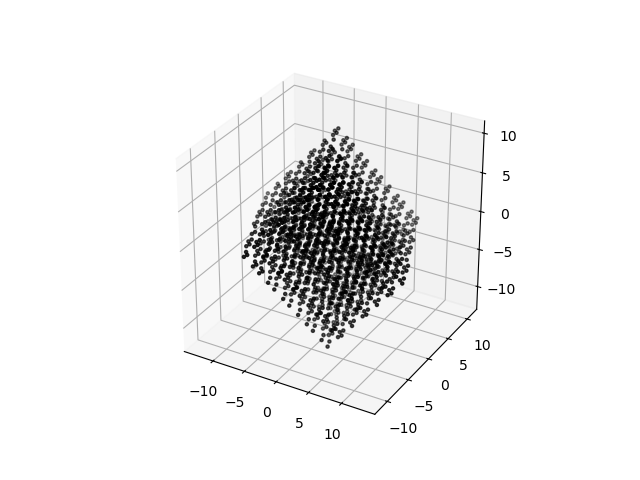

In [15]:
# visualize points in 3D
pid = '20240903_n=3_1'
data = np.load(os.path.join(data_folder, f'{pid}.npz'))
proj_pts = data['proj_pts'];
n_points = proj_pts.shape[0];
print(f'Number of points: {n_points}');

# cut_bulk = data['cut_bulk'];

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter(proj_pts[:,0], proj_pts[:,1], proj_pts[:,2],color='k',s=5);
plt.show()

In [16]:
# check anti-commutation between X and Z checks
new_hx_cc = data['hx_cc'];
new_hx_vv = data['hx_vv'];
new_hz_cc = data['hz_cc'];
new_hz_vv = data['hz_vv'];

In [8]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_box_aspect([1,1,1])
# for i in range(new_hx_cc.shape[0]):
#     for j in range(new_hx_cc.shape[1]):
#         if new_hx_cc[i,j] != 0:
#             ax.plot([proj_pts[i,0],proj_pts[j,0]],[proj_pts[i,1],proj_pts[j,1]],zs=[proj_pts[i,2],proj_pts[j,2]],color='C0',lw=1,alpha=0.5);
# for i in range(new_hz_cc.shape[0]):
#     for j in range(new_hz_cc.shape[1]):
#         if new_hz_cc[i,j] != 0:
#             ax.plot([proj_pts[i,0],proj_pts[j,0]],[proj_pts[i,1],proj_pts[j,1]],zs=[proj_pts[i,2],proj_pts[j,2]],color='C2',lw=1,alpha=0.5);
# ax.scatter(proj_pts[:,0], proj_pts[:,1],proj_pts[:,2],color='k',s=8);

# #lmask = [2,197%proj_pts.shape[1]];
# #ax.scatter(proj_pts[0,lmask],proj_pts[1,lmask],color='r',marker='*',s=100);
# plt.show()

In [17]:
new_hx = np.hstack([new_hx_cc, new_hx_vv])
new_hz = np.hstack([new_hz_cc, new_hz_vv])
# # anti_comm_mat_x = (new_hx @ new_hz.T) % 2
# anti_comm_mat_x = (new_hx @ new_hz.T)[np.ix_(cut_bulk,cut_bulk)] % 2
# np.sum(anti_comm_mat_x)

In [10]:
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_box_aspect([1,1,1])
# for i in range(anti_comm_mat_x.shape[0]):
#     for j in range(anti_comm_mat_x.shape[1]):
#         if anti_comm_mat_x[i,j] != 0:
#             if i == j:
#                 i_proj = cut_bulk[i]
#                 ax.scatter([proj_pts[i_proj,0]],[proj_pts[i_proj,1]],[proj_pts[i_proj,2]],color='r',m='*');
#             else:
#                 i_proj = cut_bulk[i]
#                 j_proj = cut_bulk[j]
#                 ax.plot([proj_pts[i_proj,0],proj_pts[j_proj,0]],[proj_pts[i_proj,1],proj_pts[j_proj,1]],zs=[proj_pts[i_proj,2],proj_pts[j_proj,2]],ls='-',lw=1,color='r');
# ax.scatter(proj_pts[:,0], proj_pts[:,1],proj_pts[:,2],color='k')
# plt.show()

In [11]:
# anti_comm_x_inds = np.where(anti_comm_mat_x != 0)
# full_to_cut_ind_map = np.load(os.path.join(data_folder, f'{pid}_map.pkl'), allow_pickle=True)
# cut_to_full_ind_map = {v:k for k,v in full_to_cut_ind_map.items()}
# cut_to_full_ind_map[cut_bulk[anti_comm_x_inds[0][1]]]

In [18]:
from ldpc import mod2
def compute_lz(hx,hz):
    #lz logical operators
    #lz\in ker{hx} AND \notin Im(Hz.T)

    ker_hx=mod2.nullspace(hx) #compute the kernel basis of hx
    im_hzT=mod2.row_basis(hz) #compute the image basis of hz.T

    #in the below we row reduce to find vectors in kx that are not in the image of hz.T.
    log_stack=np.vstack([im_hzT,ker_hx])
    pivots=mod2.row_echelon(log_stack.T)[3]
    log_op_indices=[i for i in range(im_hzT.shape[0],log_stack.shape[0]) if i in pivots]
    log_ops=log_stack[log_op_indices]

    return log_ops

In [19]:
lz = compute_lz(new_hx,new_hz)
lx = compute_lz(new_hz,new_hx)
assert len(lx) == len(lz)
k = len(lx)
print(f'Number of logical operators: {k}')

Number of logical operators: 0


In [20]:
for i in range(k):
    print(f'{i}-th L_X: {np.sum(lx[i])}')
    print(f'{i}-th L_Z: {np.sum(lz[i])}')

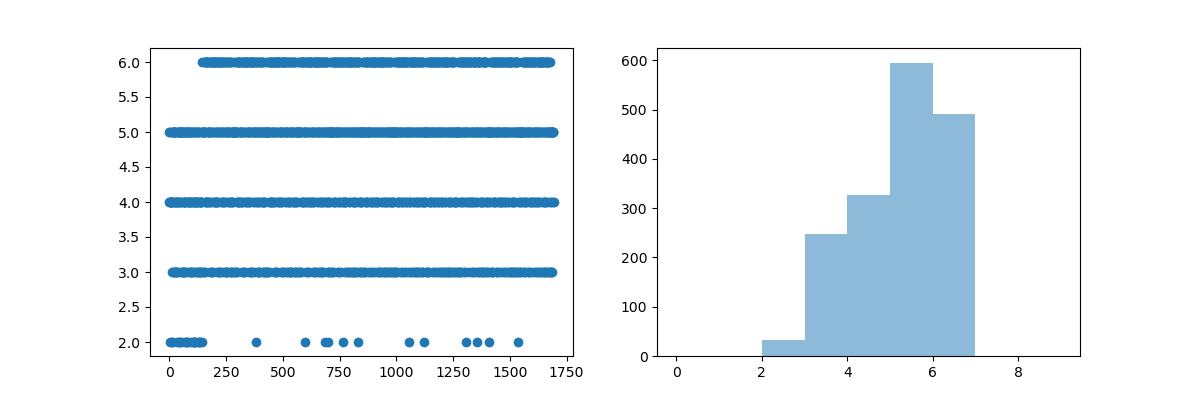

In [21]:
hx_to_vv_weights = np.sum(new_hx, axis=1)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(hx_to_vv_weights, 'o')
ax[1].hist(hx_to_vv_weights, bins=range(10), alpha=0.5, label='hx to vv weights');
plt.show()

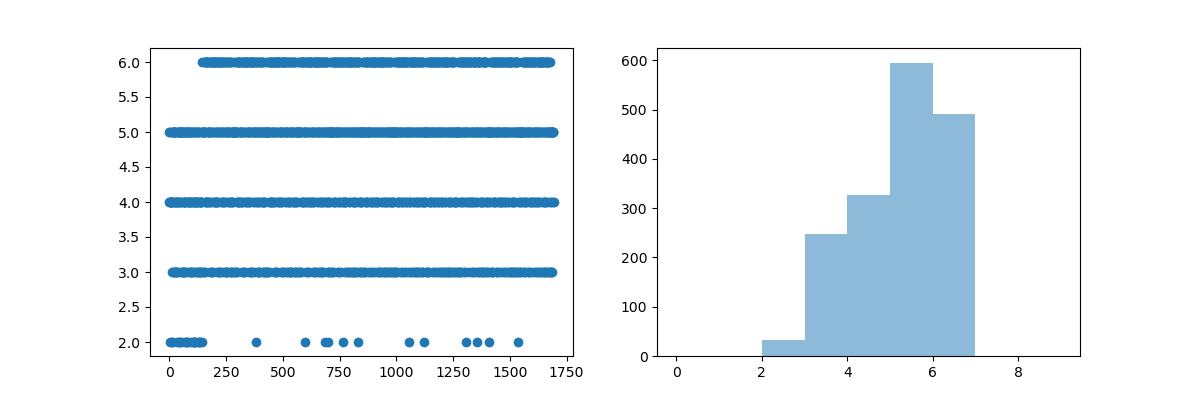

In [22]:
hx_to_cc_weights = np.sum(new_hx, axis=1)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(hx_to_cc_weights, 'o')
ax[1].hist(hx_to_cc_weights, bins=range(10), alpha=0.5, label='hx to cc weights');
plt.show()

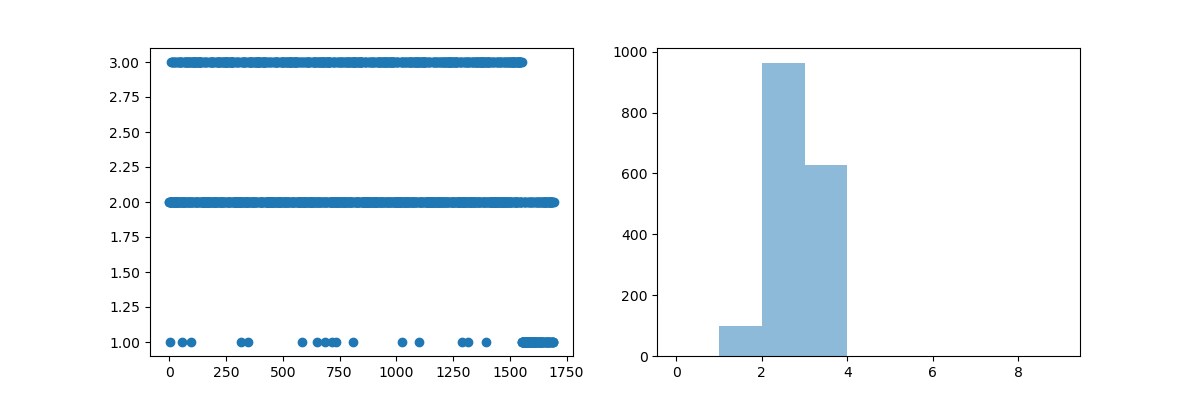

In [23]:
vv_to_hx_weights = np.sum(new_hx_vv, axis=0)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(vv_to_hx_weights, 'o')
ax[1].hist(vv_to_hx_weights, bins=range(10), alpha=0.5, label='vv to hx weights');
plt.show()

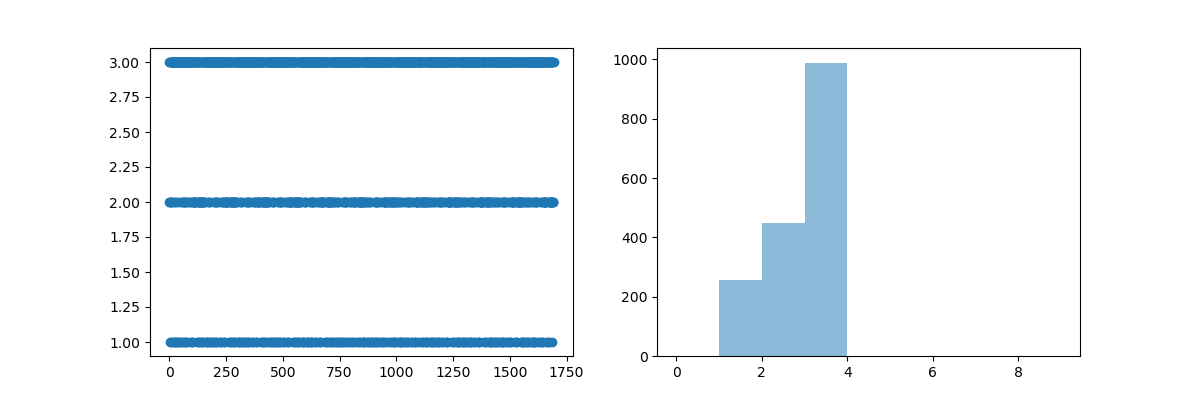

In [24]:
cc_to_hx_weights = np.sum(new_hx_cc, axis=0)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(cc_to_hx_weights, 'o')
ax[1].hist(cc_to_hx_weights, bins=range(10), alpha=0.5, label='cc to hx weights');
plt.show()

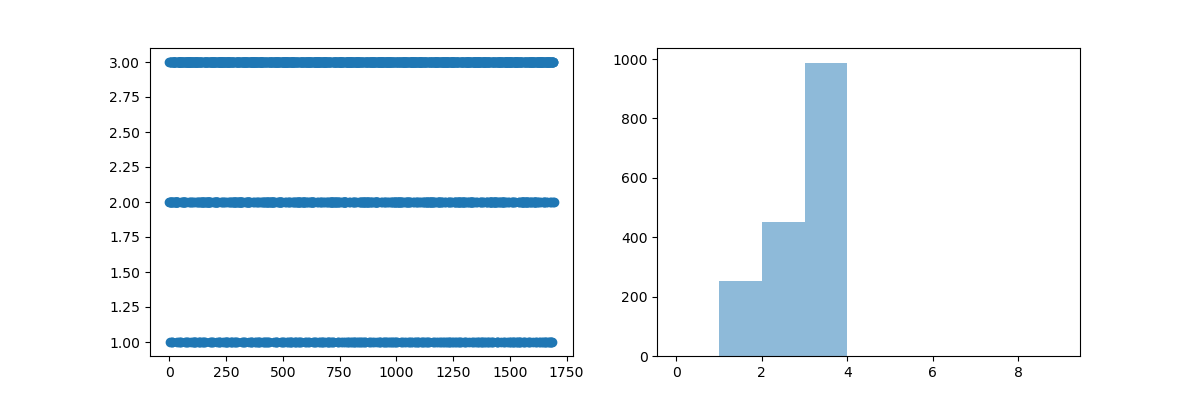

In [25]:
vv_to_hz_weights = np.sum(new_hz_vv, axis=0)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(vv_to_hz_weights, 'o')
ax[1].hist(vv_to_hz_weights, bins=range(10), alpha=0.5, label='cc to hz weights');
plt.show()

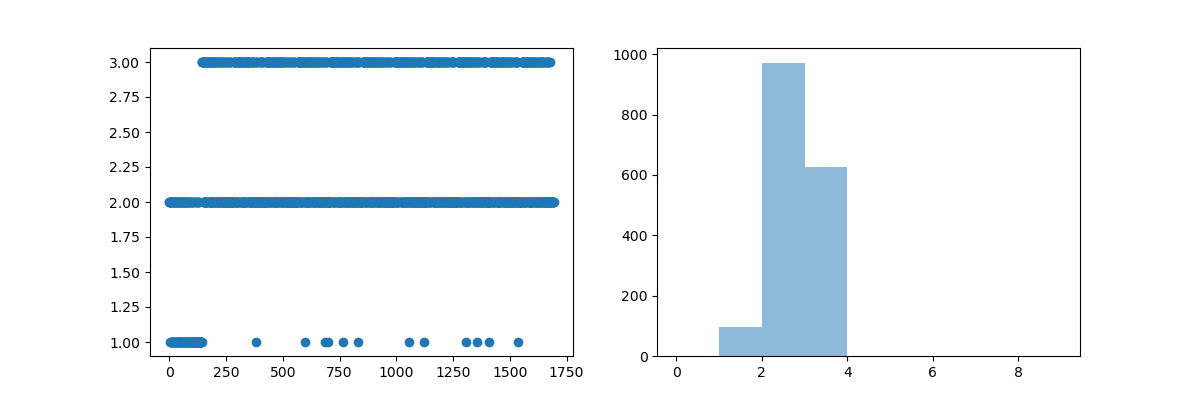

In [26]:
cc_to_hz_weights = np.sum(new_hz_cc, axis=0)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(cc_to_hz_weights, 'o')
ax[1].hist(cc_to_hz_weights, bins=range(10), alpha=0.5, label='cc to hz weights');
plt.show()

In [27]:
for i in range(new_hx_cc.shape[1]):
    if new_hx_cc[0,i] != 0 and new_hz_cc[1,i] != 0:
        print(f'{i}-th CC qubit is in both X and Z stabilizers')

for i in range(new_hx_vv.shape[1]):
    if new_hx_vv[0,i] != 0 and new_hz_vv[1,i] != 0:
        print(f'{i}-th VV qubit is in both X and Z stabilizers')

1-th CC qubit is in both X and Z stabilizers
0-th VV qubit is in both X and Z stabilizers


In [28]:
# randomly deleting some X stabilizers
k_delx = []
dx_delx = []
dz_delx = []
assert new_hx_cc.shape[1] == new_hx_cc.shape[0]
start = timer()
for i in range(new_hx.shape[0]):
    delx_hx = np.delete(new_hx, i, axis=0)
    lz = compute_lz(delx_hx, new_hz)
    lx = compute_lz(new_hz, delx_hx)
    assert len(lx) == len(lz)
    k = len(lx)
    k_delx.append(k)
    dz_delx.append(np.sum(lz[0]))
    dx_delx.append(np.sum(lx[0]))
    end = timer()
    if (end - start) > 60:
        print(f'Finished {i} deletions in {end-start} seconds')
        break


Finished 15 deletions in 63.801695259986445 seconds


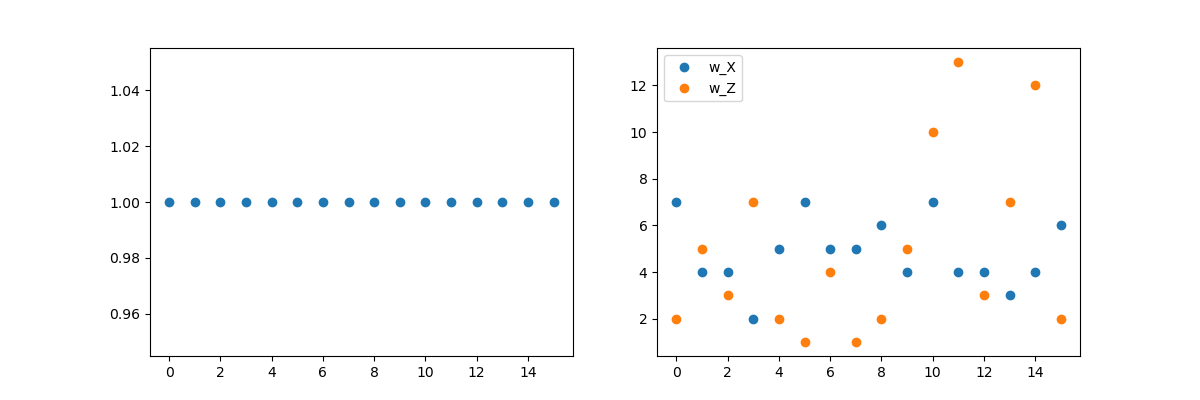

In [29]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(k_delx, 'o')
ax[1].plot(dx_delx, 'o', label='w_X')
ax[1].plot(dz_delx, 'o', label='w_Z')
plt.legend()
plt.show()

In [30]:
# randomly deleting some X stabilizers
k_delz = []
dx_delz = []
dz_delz = []
assert new_hx_cc.shape[1] == new_hx_cc.shape[0]
for i in range(new_hz.shape[0]):
    delz_hz = np.delete(new_hz, i, axis=0)
    lz = compute_lz(new_hx, delz_hz)
    lx = compute_lz(delz_hz, new_hx)
    assert len(lx) == len(lz)
    k = len(lx)
    k_delz.append(k)
    dz_delz.append(np.sum(lz[0]))
    dx_delz.append(np.sum(lx[0]))

KeyboardInterrupt: 

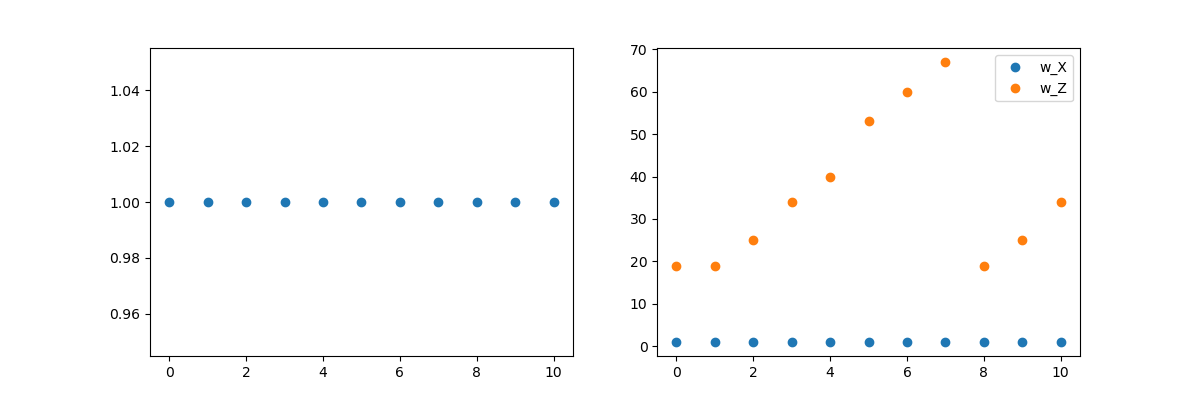

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(k_delz, 'o')
ax[1].plot(dx_delz, 'o', label='w_X')
ax[1].plot(dz_delz, 'o', label='w_Z')
plt.legend()
plt.show()

In [31]:
def delete_stabilizers(hx, hz, ind_x, ind_z, delete_mode='X'):
    assert delete_mode in ['X', 'Z'], 'delete_mode must be either X or Z'
    if delete_mode == 'X':
        del_hx = np.delete(new_hx, ind_x, axis=0)
        lz = compute_lz(del_hx, new_hz)
        lx = compute_lz(new_hz, del_hx)
    elif delete_mode == 'Z':
        del_hz = np.delete(new_hz, ind_z, axis=0)
        lz = compute_lz(new_hx, del_hz)
        lx = compute_lz(del_hz, new_hx)
    assert len(lx) == len(lz)
    return lx, lz

(16, 8)

In [38]:
# find the point closest to the origin
distances = np.linalg.norm(proj_pts, axis=1)
closest_ind = np.argmin(distances)
closest_ind

756

In [74]:
ind_x = closest_ind
ind_z = closest_ind
lx, lz = delete_stabilizers(new_hx, new_hz, ind_x, ind_z, delete_mode='X')
np.sum(lx[0]), np.sum(lz[0])

(28, 1)

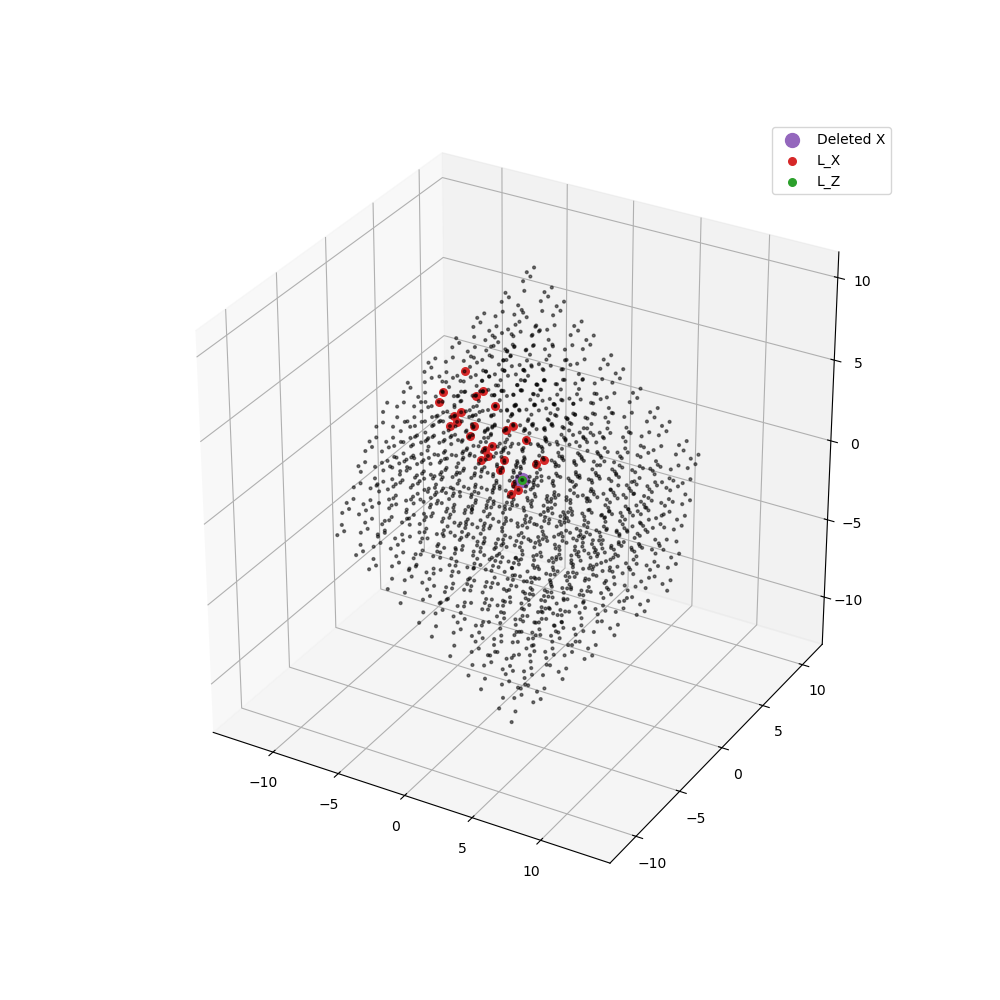

In [41]:
# visualize the logical
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
ind = closest_ind
ax.scatter([proj_pts[ind, 0]], [proj_pts[ind, 1]], [proj_pts[ind, 2]], color='C4', s=100, label='Deleted X')
x_legend_set = False
z_legend_set = False
for i in range(lx.shape[1]//2):
    if lx[0,i] or lx[0,i+lx.shape[1]//2]:
        if not x_legend_set:
            ax.scatter([proj_pts[i, 0]], [proj_pts[i, 1]], [proj_pts[i, 2]], color='C3', s=30, label='L_X')
            x_legend_set = True
        else:
            ax.scatter([proj_pts[i, 0]], [proj_pts[i, 1]], [proj_pts[i, 2]], color='C3', s=30)
for i in range(lz.shape[1]//2):
    if lz[0,i] or lz[0,i+lz.shape[1]//2]:
        if not z_legend_set:
            ax.scatter([proj_pts[i, 0]], [proj_pts[i, 1]], [proj_pts[i, 2]], color='C2', s=30, label='L_Z')
            z_legend_set = True
        else:
            ax.scatter([proj_pts[i, 0]], [proj_pts[i, 1]], [proj_pts[i, 2]], color='C2', s=30)
ax.scatter(proj_pts[:,0], proj_pts[:,1],proj_pts[:,2],color='k', s=4, alpha=0.5)
plt.legend()
plt.show()

Now let's view the connectivity that results in these specific logicals.

found CC logical, i: 756


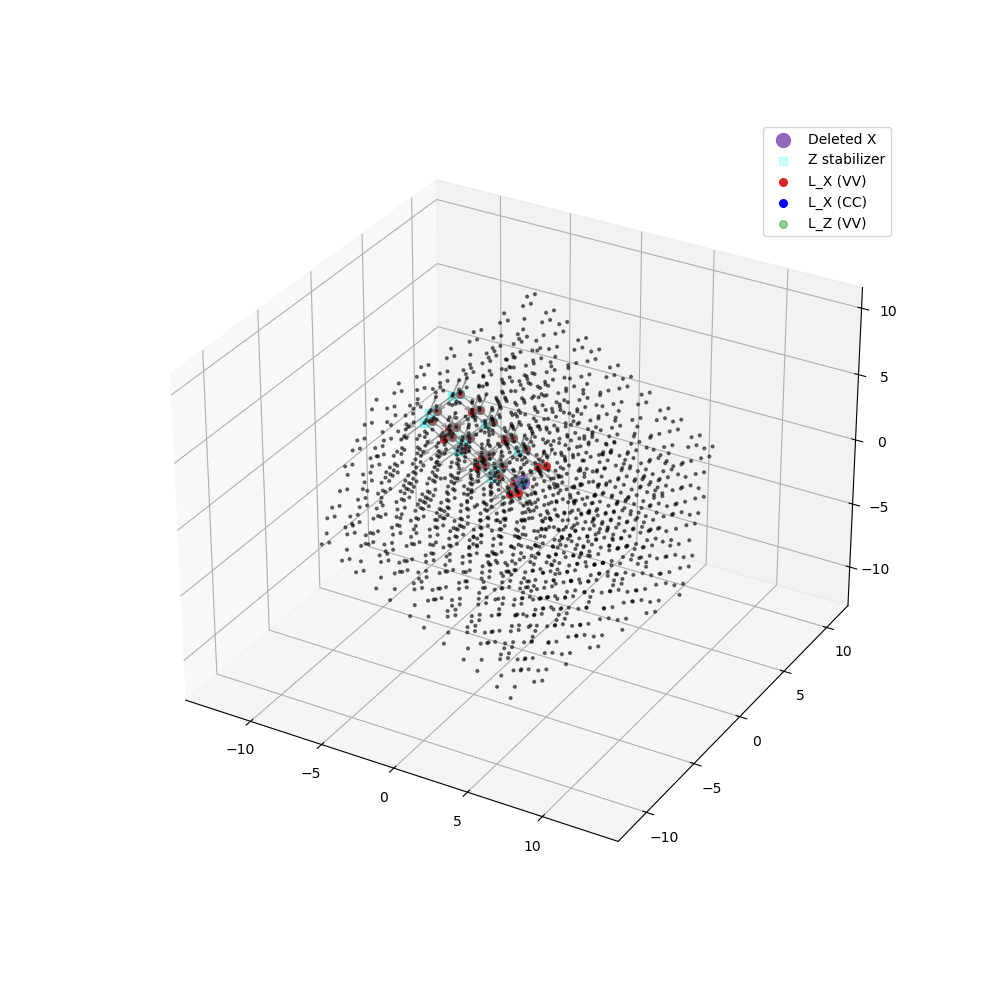

In [87]:
del_hx = new_hx.copy()
del_hx[closest_ind] = 0
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# for i in range(del_hx.shape[0]):
#     for j in range(del_hx.shape[1]//2):
#         if (lx[0,j] or lx[0,j+lx.shape[1]//2]):
#             if (del_hx[i,j] != 0 or del_hx[i, j+del_hx.shape[1]//2] != 0):
#             # ax.plot([proj_pts[i,0],proj_pts[j,0]],[proj_pts[i,1],proj_pts[j,1]],zs=[proj_pts[i,2],proj_pts[j,2]],color='gray',lw=1,alpha=0.5)
#             ax.quiver(proj_pts[i,0],proj_pts[i,1],proj_pts[i,2],proj_pts[j,0]-proj_pts[i,0],proj_pts[j,1]-proj_pts[i,1],proj_pts[j,2]-proj_pts[i,2],color='gray',lw=1,alpha=0.5)

ax.scatter([proj_pts[closest_ind, 0]], [proj_pts[closest_ind, 1]], [proj_pts[closest_ind, 2]], color='C4', s=100, label='Deleted X')
z_stab_legend_set = False
x_vv_legend_set = False
x_cc_legend_set = False
z_vv_legend_set = False
z_cc_legend_set = False
for i in range(lx.shape[1]//2):
    if lx[0,i] or lx[0,i+lx.shape[1]//2]:
        # find all the points that are connected to i
        connected_stab_inds = np.where(new_hz[:, i] != 0)[0]
        for i_stab in connected_stab_inds:
            if not z_stab_legend_set:
                ax.scatter([proj_pts[i_stab, 0]], [proj_pts[i_stab, 1]], [proj_pts[i_stab, 2]], marker='s', color='cyan',s=30, alpha=0.2, label='Z stabilizer')
                z_stab_legend_set = True
            else:
                ax.scatter([proj_pts[i_stab, 0]], [proj_pts[i_stab, 1]], [proj_pts[i_stab, 2]], marker='s', color='cyan',s=30, alpha=0.2)
            for j in np.where(new_hz[i_stab, :] != 0)[0]:
                if j < lx.shape[1]//2:
                    ax.quiver(proj_pts[i_stab, 0], proj_pts[i_stab, 1], proj_pts[i_stab, 2], proj_pts[j, 0]-proj_pts[i_stab, 0], proj_pts[j, 1]-proj_pts[i_stab, 1], proj_pts[j, 2]-proj_pts[i_stab, 2], color='gray', lw=1, alpha=0.5)
                else:
                    j_shift = j - lx.shape[1]//2
                    ax.quiver(proj_pts[i_stab, 0], proj_pts[i_stab, 1], proj_pts[i_stab, 2], proj_pts[j_shift, 0]-proj_pts[i_stab, 0], proj_pts[j_shift, 1]-proj_pts[i_stab, 1], proj_pts[j_shift, 2]-proj_pts[i_stab, 2], color='gray', lw=1, alpha=0.5)
        if lx[0,i]:
            if not x_vv_legend_set:
                ax.scatter([proj_pts[i, 0]], [proj_pts[i, 1]], [proj_pts[i, 2]], color='C3', s=30, alpha=1, label='L_X (VV)')
                x_vv_legend_set = True
            else:
                ax.scatter([proj_pts[i, 0]], [proj_pts[i, 1]], [proj_pts[i, 2]], color='C3', alpha=1, s=30)
        if lx[0,i+lx.shape[1]//2]:
            print('found CC logical, i:', i)
            if not x_cc_legend_set:
                ax.scatter([proj_pts[i, 0]], [proj_pts[i, 1]], [proj_pts[i, 2]], color='blue', s=30, alpha=1, label='L_X (CC)')
                x_cc_legend_set = True
            else:
                ax.scatter([proj_pts[i, 0]], [proj_pts[i, 1]], [proj_pts[i, 2]], color='blue', s=30, alpha=1)
for i in range(lz.shape[1]//2):
    if lz[0,i]:
        if not z_vv_legend_set:
            ax.scatter([proj_pts[i, 0]], [proj_pts[i, 1]], [proj_pts[i, 2]], color='C2', s=30, alpha=0.5, label='L_Z (VV)')
            z_vv_legend_set = True
        else:
            ax.scatter([proj_pts[i, 0]], [proj_pts[i, 1]], [proj_pts[i, 2]], color='C2', s=30, alpha=0.5)
    if lz[0,i+lz.shape[1]//2]:
        if not z_cc_legend_set:
            ax.scatter([proj_pts[i, 0]], [proj_pts[i, 1]], [proj_pts[i, 2]], color='cyan', s=30, alpha=0.5, label='L_Z (CC)')
            z_cc_legend_set = True
        else:
            ax.scatter([proj_pts[i, 0]], [proj_pts[i, 1]], [proj_pts[i, 2]], color='cyan', s=30, alpha=0.5)
ax.scatter(proj_pts[:,0], proj_pts[:,1],proj_pts[:,2],color='k', s=4, alpha=0.5)
ax.legend()

#### 2D stacking but longer logical

### Orthogonality condition

Conclusion: orthogonality condition is given by a specific feature of the Gram matrix $S_{ij}\equiv \langle \vec{e}_i, \vec{e}_j \rangle$. The feature is that some elements of $S$ are close to 0, and some are close to 1 (after proper normalization).

In [2]:
from aperiodic_codes.cut_and_project.six_to_three import proj_mat, gen_rotation
from aperiodic_codes.cut_and_project.config import tests

P = proj_mat()
proj_pos0, proj_neg0 = P[:,:3], P[:,3:]
assert proj_pos0.shape == proj_neg0.shape == (6,3)

thetas = np.array([2.594869346392367,0.9477109111037187,3.620412204482349,5.283264728923087,3.6816833892843457,-0.5959013298160938,4.382704240484682,0.09458794430181908,4.836072911632601,3.3235372560725627,1.0035735979880425,3.1895322061975233,2.793452898208629,0.3547799862139244,2.774503370428157])
offset = np.array([0.29806990830179625,0.12993246148702742,0.574709309736253,0.39003543441180044,0.13260187449328498,0.6966313017934023])
R = gen_rotation(thetas, 6)
assert R.shape == (6,6)

proj_neg = R @ proj_neg0
vec_norms = np.linalg.norm(proj_neg, axis=1)
vec_norms

array([1.63666701, 1.1500192 , 1.73191911, 1.17830125, 1.71627864,
       0.81561445])

In summary, we have formalized the criteria for the layer separation property in the 3D tiling as "orthogonality condition": The cosine of a vector with other vectors are small.

INFO:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral


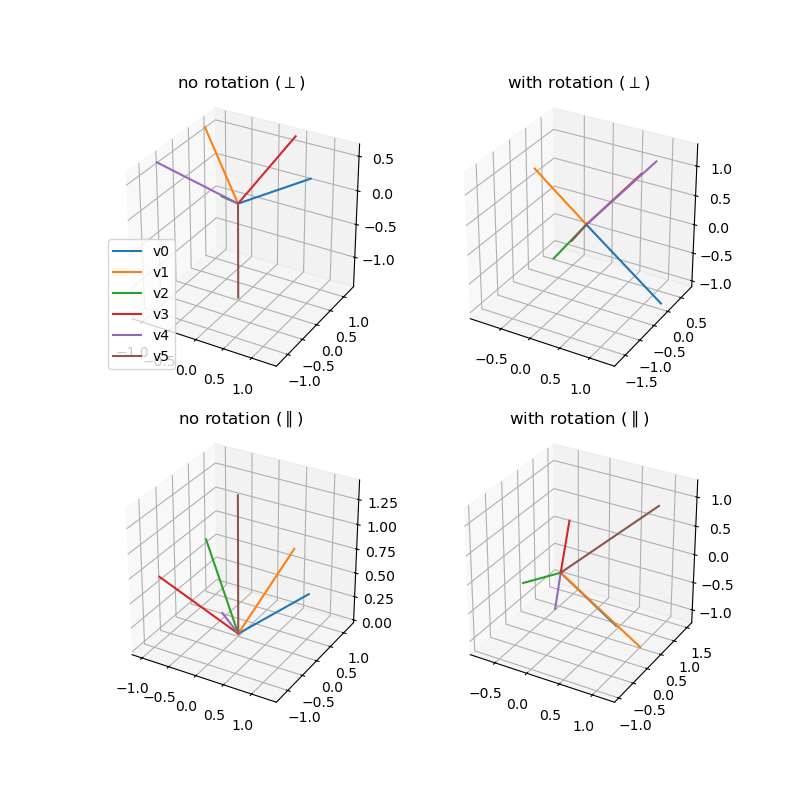

In [3]:
proj_pos0, proj_neg0 = P[:,:3], P[:,3:]
proj_pos = R @ proj_pos0
proj_neg = R @ proj_neg0

fig = plt.figure(figsize=(8,8))
ax0 = fig.add_subplot(221, projection='3d')
ax0.set_box_aspect([1,1,1])
for i in range(6):
    color_string = f'C{i}'
    ax0.set_title('no rotation ($\perp$)')
    ax0.plot([0, proj_neg0[i,0]], [0, proj_neg0[i,1]], [0, proj_neg0[i,2]], color=color_string, label=f'v{i}')
ax0.legend()
ax1 = fig.add_subplot(222, projection='3d')
ax1.set_box_aspect([1,1,1])
for i in range(6):
    color_string = f'C{i}'
    ax1.plot([0, proj_neg[i,0]], [0, proj_neg[i,1]], [0, proj_neg[i,2]], color=color_string)
    ax1.set_title('with rotation ($\perp$)')
ax2 = fig.add_subplot(223, projection='3d')
ax2.set_box_aspect([1,1,1])
for i in range(6):
    color_string = f'C{i}'
    ax2.plot([0, proj_pos0[i,0]], [0, proj_pos0[i,1]], [0, proj_pos0[i,2]], color=color_string)
    ax2.set_title('no rotation ($\parallel$)')
ax3 = fig.add_subplot(224, projection='3d')
ax3.set_box_aspect([1,1,1])
for i in range(6):
    color_string = f'C{i}'
    ax3.plot([0, proj_pos[i,0]], [0, proj_pos[i,1]], [0, proj_pos[i,2]], color=color_string)
    ax3.set_title('with rotation ($\parallel$)')

plt.show()


Observations:
1. Three groups of vectors after rotation. Here grouping is defined by alignment/anti-alignment (large value of cosine).
    * The fact that there are 3 groups gives rise to rhombohedral lattice.
2. Alignment in perpendicular space turns into anti-alignment in parallel space, and vice versa.

interactive(children=(FloatSlider(value=0.0, description='t0', max=3.141592653589793, min=-3.141592653589793, …

<function __main__.update(t0=0.0, t1=0.0, t2=0.0, t3=0.0, t4=0.0, t5=0.0, t6=0.0, t7=0.0, t8=0.0, t9=0.0, t10=0.0, t11=0.0, t12=0.0, t13=0.0, t14=0.0)>

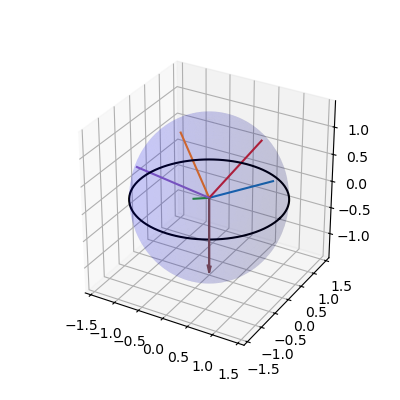

In [4]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111,projection='3d')
ax.set_box_aspect([1,1,1])
ax.set_xlim()

def update(t0=0.0 , t1=0.0 , t2=0.0 , t3=0.0 , t4=0.0 , t5=0.0 , t6=0.0 , t7=0.0 , t8=0.0 , t9=0.0, t10=0.0, t11=0.0, t12=0.0, t13=0.0, t14=0.0):
    ax.clear()
    R = gen_rotation((t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14),6)
    proj_neg0 = P[:,3:]
    proj_neg = R @ proj_neg0
    vec_ind = 5
    ax.quiver(0,0,0,proj_neg[vec_ind,0],proj_neg[vec_ind,1],proj_neg[vec_ind,2],color=f'C{vec_ind}',arrow_length_ratio=0.1)
    ax.plot([0,proj_neg[vec_ind,0]],[0,proj_neg[vec_ind,1]],[0,proj_neg[vec_ind,2]],color=f'C{vec_ind}')
    for i in range(6):
        if i == vec_ind:
            continue
        color_string = f'C{i}'
        ax.plot([0, proj_neg0[i,0]], [0, proj_neg0[i,1]], [0, proj_neg0[i,2]], color=color_string)
    # draw a 2D shpere centered at the origin
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.sqrt(2)*np.outer(np.cos(u), np.sin(v))
    y = np.sqrt(2)*np.outer(np.sin(u), np.sin(v))
    z = np.sqrt(2)*np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='b', alpha=0.1)
    # draw the equator
    ax.plot(np.sqrt(2)*np.cos(u), np.sqrt(2)*np.sin(u), 0, color='k')
    print(f'Vector {vec_ind} norm: {np.linalg.norm(proj_neg[vec_ind])}')
    
from math import pi
interact(update,t0=(-pi,pi,pi/30),t1=(-pi,pi,pi/30),t2=(-pi,pi,pi/30),t3=(-pi,pi,pi/30),t4=(-pi,pi,pi/30),t5=(-pi,pi,pi/30),t6=(-pi,pi,pi/30),t7=(-pi,pi,pi/30),t8=(-pi,pi,pi/30),t9=(-pi,pi,pi/30),t10=(-pi,pi,pi/30),t11=(-pi,pi,pi/30),t12=(-pi,pi,pi/30),t13=(-pi,pi,pi/30),t14=(-pi,pi,pi/30))

Here we examine the "symmetric mode", i.e., simutaneously rotaing along five planes. This symmetric rotational mode can gives rise to the fully diagonal case.

interactive(children=(FloatSlider(value=0.0, description='t', max=3.141592653589793, min=-3.141592653589793, s…

<function __main__.update(t)>

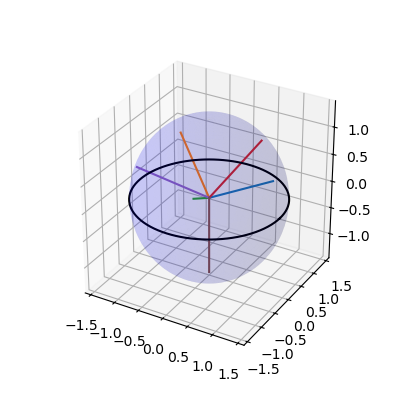

In [5]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111,projection='3d')
ax.set_box_aspect([1,1,1])
ax.set_xlim()

def update(t):
    ax.clear()
    thetas = np.array([0,0,0,0,t,0,0,0,t,0,0,t,0,t,t])
    assert thetas.shape == (15,)
    R = gen_rotation(thetas, 6)
    proj_neg0 = P[:,3:]
    proj_neg = R @ proj_neg0
    vec_ind = 5
    for i in range(6):
        color_string = f'C{i}'
        ax.plot([0, proj_neg[i,0]], [0, proj_neg[i,1]], [0, proj_neg[i,2]], color=color_string)
    # draw a 2D shpere centered at the origin
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.sqrt(2)*np.outer(np.cos(u), np.sin(v))
    y = np.sqrt(2)*np.outer(np.sin(u), np.sin(v))
    z = np.sqrt(2)*np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='b', alpha=0.1)
    # draw the equator
    ax.plot(np.sqrt(2)*np.cos(u), np.sqrt(2)*np.sin(u), 0, color='k')
    print(f'{np.dot(proj_neg[0],proj_neg[5])}')
    
from math import pi
interact(update,t=(-pi,pi,pi/30))

Here we examine the variance matrix of the symmetric fully diagonal case. But the numerical value doesn't match Brenden's. Need to ask Brenden tomorrow about the exact defnition of the variance matrix.

In [6]:
v = np.array([
    [0,0,1],
    [1,0,0],
    [np.cos(2*np.pi/5), np.sin(2*np.pi/5), 0],
    [np.cos(4*np.pi/5), np.sin(4*np.pi/5), 0],
    [np.cos(6*np.pi/5), np.sin(6*np.pi/5), 0],
    [np.cos(8*np.pi/5), np.sin(8*np.pi/5), 0],
])
gram = np.zeros((5,5))
for i in range(2,6):
    for j in range(2,6):
        gram[i-1,j-1] = np.dot(v[i], v[j])
np.var(np.abs(gram.flatten()))

0.15653498966400806

### Understand the structure of tiling in parallel space

In [40]:
from aperiodic_codes.cut_and_project.six_to_three import proj_mat, gen_rotation
from aperiodic_codes.cut_and_project.config import tests
from itertools import combinations

P = proj_mat()
proj_pos0, proj_neg0 = P[:,:3], P[:,3:]
assert proj_pos0.shape == proj_neg0.shape == (6,3)

# thetas = np.array([2.594869346392367,0.9477109111037187,3.620412204482349,5.283264728923087,3.6816833892843457,-0.5959013298160938,4.382704240484682,0.09458794430181908,4.836072911632601,3.3235372560725627,1.0035735979880425,3.1895322061975233,2.793452898208629,0.3547799862139244,2.774503370428157])
# offset = np.array([0.29806990830179625,0.12993246148702742,0.574709309736253,0.39003543441180044,0.13260187449328498,0.6966313017934023])
thetas = np.zeros(15)
offset = np.zeros(6)
R = gen_rotation(thetas, 6)
assert R.shape == (6,6)
assert np.allclose(R, np.eye(6))

def gen_triacontahedron(proj_neg):
    assert proj_neg.shape == (6,3)
    rhomb_inds = [
        (0,3,1),
        (3,1,4),
        (1,4,2),
        (4,2,0),
        (0,3,5),
        (3,1,5),
        (1,4,5),
        (4,2,5),
        (2,0,5)
    ]
    rhombs = []
    rhomb_visuals = []
    def face_visual(v1, v2, shift):
        w1, w2 = np.meshgrid([0,1], [0,1])
        X, Y, Z = w1*v1[0] + w2*v2[0] + shift[0], w1*v1[1] + w2*v2[1] + shift[1], w1*v1[2] + w2*v2[2] + shift[2]
        return X, Y, Z
    for ri in rhomb_inds[:1]+rhomb_inds[-5:]:
        if ri == (0,3,1):
            rhomb_visuals.append(face_visual(proj_neg[ri[0]], proj_neg[ri[1]], proj_neg[5]+proj_neg[3]))
            rhomb_visuals.append(face_visual(proj_neg[ri[1]], proj_neg[ri[2]], proj_neg[5]+proj_neg[3]))
            rhomb_visuals.append(face_visual(proj_neg[ri[2]], proj_neg[ri[0]], proj_neg[5]+proj_neg[3]))
        else:
            rhombs.append([proj_neg[ri[0]], proj_neg[ri[1]], proj_neg[ri[2]]])
            rhomb_visuals.append(face_visual(proj_neg[ri[0]], proj_neg[ri[1]], np.zeros(3)))
            rhomb_visuals.append(face_visual(proj_neg[ri[1]], proj_neg[ri[2]], np.zeros(3)))
            rhomb_visuals.append(face_visual(proj_neg[ri[2]], proj_neg[ri[0]], np.zeros(3)))
            rhomb_visuals.append(face_visual(proj_neg[ri[0]], proj_neg[ri[1]], proj_neg[ri[2]]))
            rhomb_visuals.append(face_visual(proj_neg[ri[1]], proj_neg[ri[2]], proj_neg[ri[0]]))
            rhomb_visuals.append(face_visual(proj_neg[ri[2]], proj_neg[ri[0]], proj_neg[ri[1]]))
        
    return rhombs, rhomb_visuals
    

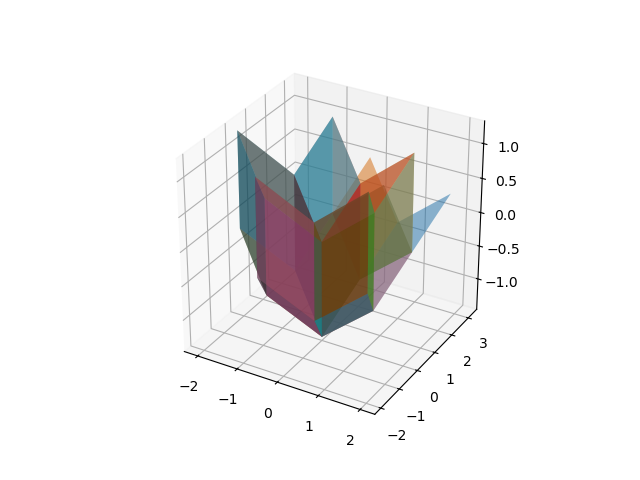

In [41]:
proj_neg = R @ proj_neg0
rhombs, rhomb_visuals = gen_triacontahedron(proj_neg)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
# plot the 2D plane defined by x-y=0
for rv in rhomb_visuals:
    ax.plot_surface(*rv, alpha=0.5)

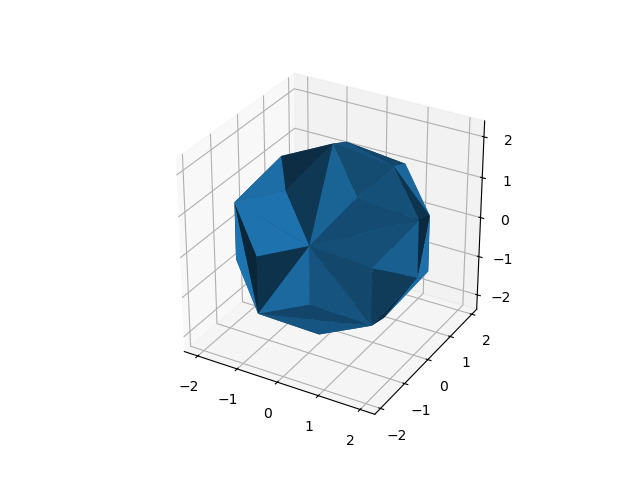

In [104]:
from aperiodic_codes.cut_and_project.cnp_utils import gen_voronoi
from scipy.spatial import ConvexHull
voronoi = np.array(np.meshgrid(*([[-1/2, 1/2]]*6),indexing='ij')).reshape(6, -1).T
triacontahedron = ConvexHull(voronoi @ proj_neg)
assert len(triacontahedron.simplices) == 60, \
    f'len(triacontahedron.simplices): {len(triacontahedron.simplices)}'

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
ax.plot_trisurf(voronoi @ proj_neg[:,0], voronoi @ proj_neg[:,1], voronoi @ proj_neg[:,2], triangles=triacontahedron.simplices)
plt.show()

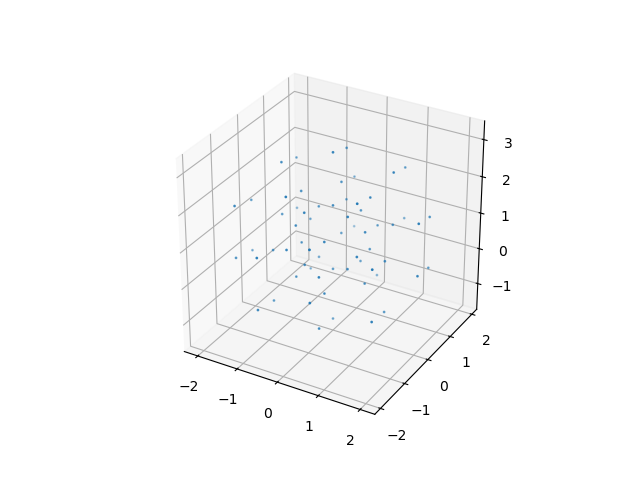

In [105]:
# point cloud approach to the triacontahedron
n_pts = 10000
seed = 0
rng = np.random.default_rng(seed)
sixd_pts = np.array(np.meshgrid(*([[0, 1]]*6),indexing='ij')).reshape(6, -1).T
threed_pts = sixd_pts @ proj_neg

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter(threed_pts[:,0], threed_pts[:,1], threed_pts[:,2], s=1)
plt.show()

In [111]:
assert len(triacontahedron.vertices) ==32
assert len(triacontahedron.equations) == 60
# for i in triacontahedron.vertices:
#     print(i, voronoi[i])
print(triacontahedron.equations[0])

[ 5.25731112e-01 -3.10316769e-16  8.50650808e-01 -1.94649798e+00]


In [126]:
def pt_inds_on_hull(pts, hull):
    pt_inds = []
    for i, pt in enumerate(pts):
        on_hull = False
        pt_3d = pt @ proj_neg
        for equation in hull.equations:
            if np.allclose(np.dot(equation[:3], pt_3d) + equation[3], 0, atol=1e-4):
                on_hull = True
                break
        if on_hull:
            pt_inds.append(i)
    return pt_inds

def pt_inds_in_hull(pts, hull):
    pt_inds = []
    for i, pt in enumerate(pts):
        in_hull = True
        pt_3d = pt @ proj_neg
        for equation in hull.equations:
            if not (np.dot(equation[:3], pt_3d) + equation[3] < 0):
                in_hull = False
                break
        if in_hull:
            pt_inds.append(i)
    return pt_inds

on_hull_inds = pt_inds_on_hull(voronoi, triacontahedron)
in_hull_inds = pt_inds_in_hull(voronoi, triacontahedron)
out_hull_inds = list(set(range(64)) - set(on_hull_inds) - set(in_hull_inds))
print(f'# on hull: {len(on_hull_inds)}; # in hull: {len(in_hull_inds)}; # out of hull: {len(out_hull_inds)}')

# on hull: 32; # in hull: 32; # out of hull: 0


In [125]:
for equation in triacontahedron.equations:
    print(equation)

[ 5.25731112e-01 -3.10316769e-16  8.50650808e-01 -1.94649798e+00]
[ 5.25731112e-01 -3.10316769e-16  8.50650808e-01 -1.94649798e+00]
[ 0.68819096  0.5         0.52573111 -1.94649798]
[ 0.68819096  0.5         0.52573111 -1.94649798]
[ 0.95105652 -0.30901699 -0.         -1.94649798]
[ 0.95105652 -0.30901699 -0.         -1.94649798]
[ 0.95105652  0.30901699  0.         -1.94649798]
[ 0.95105652  0.30901699  0.         -1.94649798]
[ 0.4253254  -0.30901699 -0.85065081 -1.94649798]
[ 0.4253254  -0.30901699 -0.85065081 -1.94649798]
[ 8.50650808e-01 -1.55158385e-16 -5.25731112e-01 -1.94649798e+00]
[ 8.50650808e-01 -1.55158385e-16 -5.25731112e-01 -1.94649798e+00]
[-0.          1.          0.         -1.94649798]
[-0.          1.          0.         -1.94649798]
[ 0.58778525  0.80901699  0.         -1.94649798]
[ 0.58778525  0.80901699  0.         -1.94649798]
[-0.16245985  0.5        -0.85065081 -1.94649798]
[-0.16245985  0.5        -0.85065081 -1.94649798]
[ 0.4253254   0.30901699 -0.85065081

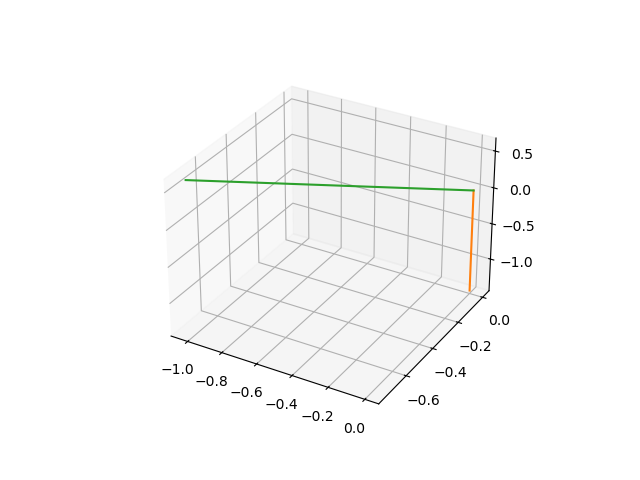

In [96]:
v1_3d = v1 @ proj_neg0
v2_3d = v2 @ proj_neg0
v3_3d = v3 @ proj_neg0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot([0, v1_3d[0]], [0, v1_3d[1]], [0, v1_3d[2]])
ax.plot([0, v2_3d[0]], [0, v2_3d[1]], [0, v2_3d[2]])
ax.plot([0, v3_3d[0]], [0, v3_3d[1]], [0, v3_3d[2]])
plt.show()